In [70]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
from torch import nn, optim
from torch.optim import lr_scheduler
from torchvision import transforms, models, datasets
import numpy as np  
import pandas as pd  
import torchvision
import matplotlib.pyplot as plt

import copy
train_on_gpu = torch.cuda.is_available()

import warnings
warnings.filterwarnings('ignore')

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU')
else:
    print('CUDA is available!  Training on GPU')

CUDA is available!  Training on GPU


In [71]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [72]:
from google.colab import files

files.upload()   # upload kaggle.json for downloading the dataset

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yauhenikavaliou","key":"5deb9439ecec8ef014fc31d185dcd4d4"}'}

In [73]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [74]:
! chmod 600 ~/.kaggle/kaggle.json

In [75]:
! kaggle datasets list  # just check is everything OK

ref                                                       title                                         size  lastUpdated          downloadCount  
--------------------------------------------------------  -------------------------------------------  -----  -------------------  -------------  
michau96/restaurant-business-rankings-2020                Restaurant Business Rankings 2020             16KB  2021-01-30 14:20:45           3633  
gpreda/reddit-wallstreetsbets-posts                       Reddit WallStreetBets Posts                    8MB  2021-02-25 09:03:43           1813  
yorkehead/stock-market-subreddits                         Stock Market Subreddits                        1MB  2021-01-29 13:53:50            358  
aagghh/crypto-telegram-groups                             Crypto telegram groups                       297MB  2021-02-02 09:58:25            214  
timoboz/superbowl-history-1967-2020                       Superbowl History 1967 - 2020                  2KB  2020-02-

In [76]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 5.4MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.10-cp37-none-any.whl size=73269 sha256=e5b91703d3eaeb1ba1291b065e4ba4681b4dcccc43a60a133d9053a720f1ac53
  Stored in directory: /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10
Successfully built kaggle
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10


In [ ]:
#@title DOWNLOAD FILES 


In [180]:
# Link for the dataset: https://www.kaggle.com/wanderdust/skin-lesion-analysis-toward-melanoma-detection

In [77]:
! kaggle datasets download -d wanderdust/skin-lesion-analysis-toward-melanoma-detection

100% 11.3G/11.3G [03:06<00:00, 82.7MB/s]
100% 11.3G/11.3G [03:06<00:00, 65.1MB/s]


In [78]:
!ls -l /content/skin-lesion-analysis-toward-melanoma-detection.zip

-rw-r--r-- 1 root root 12143517511 Feb 26 07:50 /content/skin-lesion-analysis-toward-melanoma-detection.zip


In [79]:
!unzip -q /content/skin-lesion-analysis-toward-melanoma-detection.zip

In [80]:
!ls -l /content/skin-lesions/

total 12
drwxr-xr-x 5 root root 4096 Feb 26 07:51 test
drwxr-xr-x 5 root root 4096 Feb 26 07:52 train
drwxr-xr-x 5 root root 4096 Feb 26 07:53 valid


In [81]:
train_dir = '/content/skin-lesions/train'
valid_dir = '/content/skin-lesions/valid'
test_dir = '/content/skin-lesions/test'

dirs = {'train': train_dir,
        'valid': valid_dir,
        'test': test_dir}

In [82]:
import os

melanoma = os.listdir(path='/content/skin-lesions/train/melanoma')
nevus = os.listdir(path='/content/skin-lesions/train/nevus') 
keratosis = os.listdir(path='/content/skin-lesions/train/seborrheic_keratosis/')

print(len(melanoma), len(nevus), len(keratosis))

374 1372 254


In [92]:
# IMSIZE = 229 - for inception
# IMSIZE = 224 for other

IMSIZE = 224

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(90),
        transforms.RandomPerspective(distortion_scale=0.1, p=0.3),
        transforms.Resize((256, 256)), 
        transforms.CenterCrop(IMSIZE),    # (224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                            [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(IMSIZE),           # (224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((IMSIZE, IMSIZE)),         # ((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
}

In [93]:
# Load the datasets with ImageFolder
image_datasets = {x: datasets.ImageFolder(dirs[x],   transform=data_transforms[x]) for x in ['train', 'valid', 'test']}
# load the data into batches
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=25, shuffle=True) for x in ['train', 'valid', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}

In [87]:
dataset_sizes

{'test': 600, 'train': 2000, 'valid': 150}

In [88]:
class_names = image_datasets['train'].classes
print(class_names)

['melanoma', 'nevus', 'seborrheic_keratosis']


In [89]:
class_decoder = {0: 'melanoma', 1: 'nevus', 2: 'seborrheic_keratosis'}

tensor([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
        2])


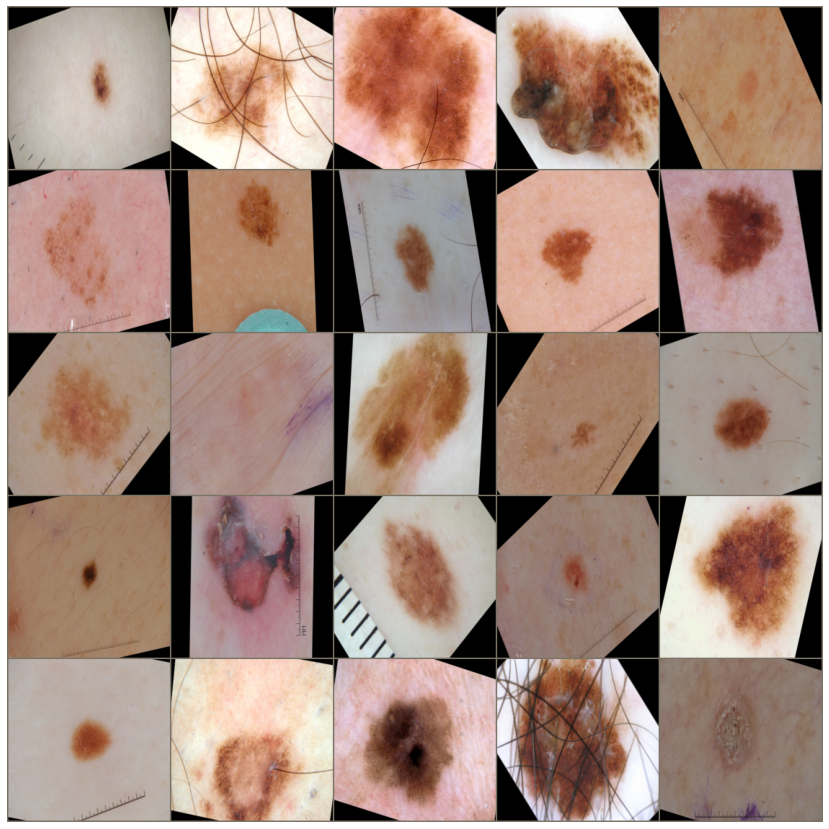

In [94]:
def imshow(image):
  if isinstance(image, torch.Tensor):
    image = image.numpy().transpose((1, 2, 0))
  else:
    image = np.array(image).transpose((1, 2, 0))
  
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  image = std * image + mean
  image = np.clip(image, 0, 1)

  fig, ax = plt.subplots(1, 1, figsize=(15, 15))
  plt.imshow(image)
  ax.axis('off')

images, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(images, nrow=5)
print(classes)
imshow(out)

In [316]:
model = models.resnet152(pretrained=True)   # aux_logits=False for inception

In [317]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [318]:
for param in model.parameters():
  param.requires_grad = False

    
for param in model.layer4[0].parameters():
    param.requires_grad = True


model.fc = nn.Linear(in_features=2048, out_features=3, bias=True)

In [319]:
lrs = []
for param in model.parameters():
  lrs.append(param.requires_grad)
print(lrs)

[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False

In [320]:
import time

In [321]:
# model to GPU
model.cuda();
#model.eval()

In [322]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, device='cuda'):
  """
  Support function for model training.

  Args:
    model: Model to be trained
    criterion: Optimization criterion (loss)
    optimizer: Optimizer to use for training
    scheduler: Instance of ``torch.optim.lr_scheduler``
    num_epochs: Number of epochs
    device: Device to run the training on. Must be 'cpu' or 'cuda'
  """
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'valid']:
      if phase == 'train':
        model.train()  # Set model to training mode
      else:
        model.eval()   # Set model to evaluate mode

      running_loss = 0.0
      running_corrects = 0

      # Iterate over data.
      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          # backward + optimize only if in training phase
          if phase == 'train':
            loss.backward()
            optimizer.step()

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
      if phase == 'train':
        scheduler.step()

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]

      print('{} loss: {:.4f} acc: {:.4f}'.format(
        phase, epoch_loss, epoch_acc))

      # deep copy the model
      if phase == 'valid' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    print()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model

In [323]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
    
        loss = nn.CrossEntropyLoss()(inputs, targets)

        pt = torch.exp(-loss)
        F_loss = self.alpha * (1-pt)**self.gamma * loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [324]:
# criterion = nn.CrossEntropyLoss()
criterion = FocalLoss()

optimizer = optim.Adam(model.parameters(), lr=5e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
num_epochs=30

In [325]:
# training
model = train_model(model, criterion, optimizer, scheduler, num_epochs, 'cuda')

Epoch 1/30
----------
train loss: 0.1742 acc: 0.7230
valid loss: 0.1500 acc: 0.7467

Epoch 2/30
----------
train loss: 0.0861 acc: 0.7935
valid loss: 0.1415 acc: 0.7600

Epoch 3/30
----------
train loss: 0.0631 acc: 0.8230
valid loss: 0.1337 acc: 0.7733

Epoch 4/30
----------
train loss: 0.0471 acc: 0.8440
valid loss: 0.0924 acc: 0.8133

Epoch 5/30
----------
train loss: 0.0439 acc: 0.8535
valid loss: 0.1113 acc: 0.7800

Epoch 6/30
----------
train loss: 0.0362 acc: 0.8650
valid loss: 0.1057 acc: 0.7933

Epoch 7/30
----------
train loss: 0.0209 acc: 0.8980
valid loss: 0.1141 acc: 0.8067

Epoch 8/30
----------
train loss: 0.0126 acc: 0.9200
valid loss: 0.0793 acc: 0.8000

Epoch 9/30
----------
train loss: 0.0117 acc: 0.9155
valid loss: 0.0742 acc: 0.8200

Epoch 10/30
----------
train loss: 0.0110 acc: 0.9180
valid loss: 0.0953 acc: 0.8133

Epoch 11/30
----------
train loss: 0.0110 acc: 0.9240
valid loss: 0.0772 acc: 0.8133

Epoch 12/30
----------
train loss: 0.0100 acc: 0.9335
valid los

In [ ]:
#@title SAVE MODEL FOR INFERENCE

In [326]:
# Saving the checkpoint 
model.class_to_idx = image_datasets['train'].class_to_idx
model.cpu()
torch.save({'state_dict': model.state_dict(),
            'class_to_idx': model.class_to_idx},
            '/content/gdrive/MyDrive/lesion_clas_resnet152_focalloss.pth')

# torch.save(model.sate_dict, "classifier.pt")

In [ ]:
#@title MAKING PREDICTIONS


In [95]:
model.cuda();
# model.eval();

In [96]:
def predict(model, inputs):
    """
    Makes predictions for data from trainloader
    using trained model
   
    Args:
        model: Model has been trained
        inputs: testing dataloader with images and labels
    
    Retutn:
        list of predicted labels
        list of true labels
    """
    with torch.no_grad():
        logits = []
        temp_labels = []
        for image, label in inputs:

            # colect true labels
            label = label.detach().cpu().numpy()
            temp_labels.append(label)

            # predict labels with model
            image = image.to('cuda')
            model.eval()
            output = model(image)
            output = output.to('cpu')
            logits.append(output)

    # collect labels into one list
    true_labels = []
    for i in range(len(temp_labels)):
        true_labels += list(temp_labels[i])

    # transform predictions and get indexes with argmax
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    predictions = [np.argmax(x) for x in probs]

    return predictions, true_labels

In [97]:
predictions, true_labels = predict(model, dataloaders['test'])

In [98]:
len(predictions), len(true_labels)

(600, 600)

In [220]:
df = pd.DataFrame({'predictions': predictions, 'true_lebels': true_labels})
df.head(30).T

0   1   2   3   4   5   6   7   ...  22  23  24  25  26  27  28  29
predictions   1   0   1   1   0   1   1   1  ...   2   0   1   2   1   1   2   2
true_lebels   1   0   1   1   0   1   1   1  ...   0   0   1   2   1   0   2   1

[2 rows x 30 columns]

In [221]:
df['predictions'] = df['predictions'].map(class_decoder)
df['true_lebels'] = df['true_lebels'].map(class_decoder)

In [222]:
df.head()

predictions true_lebels
0       nevus       nevus
1    melanoma    melanoma
2       nevus       nevus
3       nevus       nevus
4    melanoma    melanoma

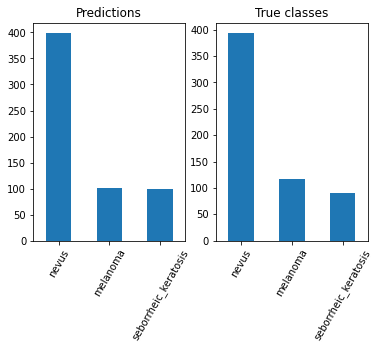

In [223]:
plt.subplot(1, 2, 1)
df['predictions'].value_counts().plot(kind='bar')
plt.title('Predictions')
plt.xticks(rotation=60)
plt.subplot(1, 2, 2)
df['true_lebels'].value_counts().plot(kind='bar')
plt.title('True classes')
plt.xticks(rotation=60)
plt.show()

In [224]:
import sklearn
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

In [225]:
acc = accuracy_score(df.true_lebels, df.predictions, normalize='weighted')
print('Accuracy: {:.3f}'.format(acc))

Accuracy: 0.763


In [226]:
quality = precision_recall_fscore_support(df.true_lebels, df.predictions, beta=1.0, average='weighted')
print('Precision: {:.3f} \nRecall: {:.3f} \nF_score: {:.3f}'.format(quality[0], quality[1], quality[2]))

Precision: 0.760 
Recall: 0.763 
F_score: 0.761


In [227]:
print(class_names)
print()
sklearn.metrics.confusion_matrix(df.true_lebels, df.predictions)

['melanoma', 'nevus', 'seborrheic_keratosis']



array([[ 59,  42,  16],
       [ 34, 337,  22],
       [  9,  19,  62]])

In [ ]:
#@title PREDICTION FOR A CUSTOM IMAGE

In [171]:
import PIL
from IPython.display import Image 

loader = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.CenterCrop(IMSIZE), 
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
])

def image_loader(image_name):
    """Load image, returns cuda tensor"""
    image = PIL.Image.open(image_name)
    image = loader(image).float()
    image = Variable(image, requires_grad=False)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image.cuda()  #assumes that you're using GPU

In [145]:
def predict_one_sample(model, inputs, device='cuda', decoder=class_decoder):
    """Prediction for a custom image"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
        predicted_class = np.argmax(probs)
        print('Lession in the image is:', class_decoder[predicted_class].upper())

In [17]:
from google.colab import files

input_image = files.upload()

Saving 1543760595_melanoma-2.jpg to 1543760595_melanoma-2.jpg
Saving keratosis.jpg to keratosis.jpg
Saving melanoma (1).jpg to melanoma (1).jpg
Saving melanoma.jpg to melanoma.jpg
Saving melanoma1232.jpg to melanoma1232.jpg
Saving melanoom-9.jpg to melanoom-9.jpg
Saving naevusnaevocellularis1.jpg to naevusnaevocellularis1.jpg
Saving nevus.jpg to nevus.jpg


Lession in the image is: SEBORRHEIC_KERATOSIS


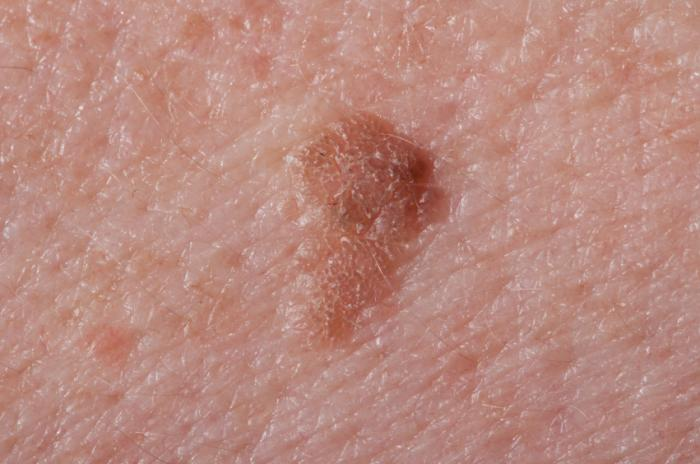

In [172]:
PATH_TO_IMAGE = '/content/keratosis.jpg'
inputs = image_loader(PATH_TO_IMAGE)

predict_one_sample(model, inputs)

pil_img = Image(filename=PATH_TO_IMAGE)
display(pil_img)

Lession in the image is: NEVUS


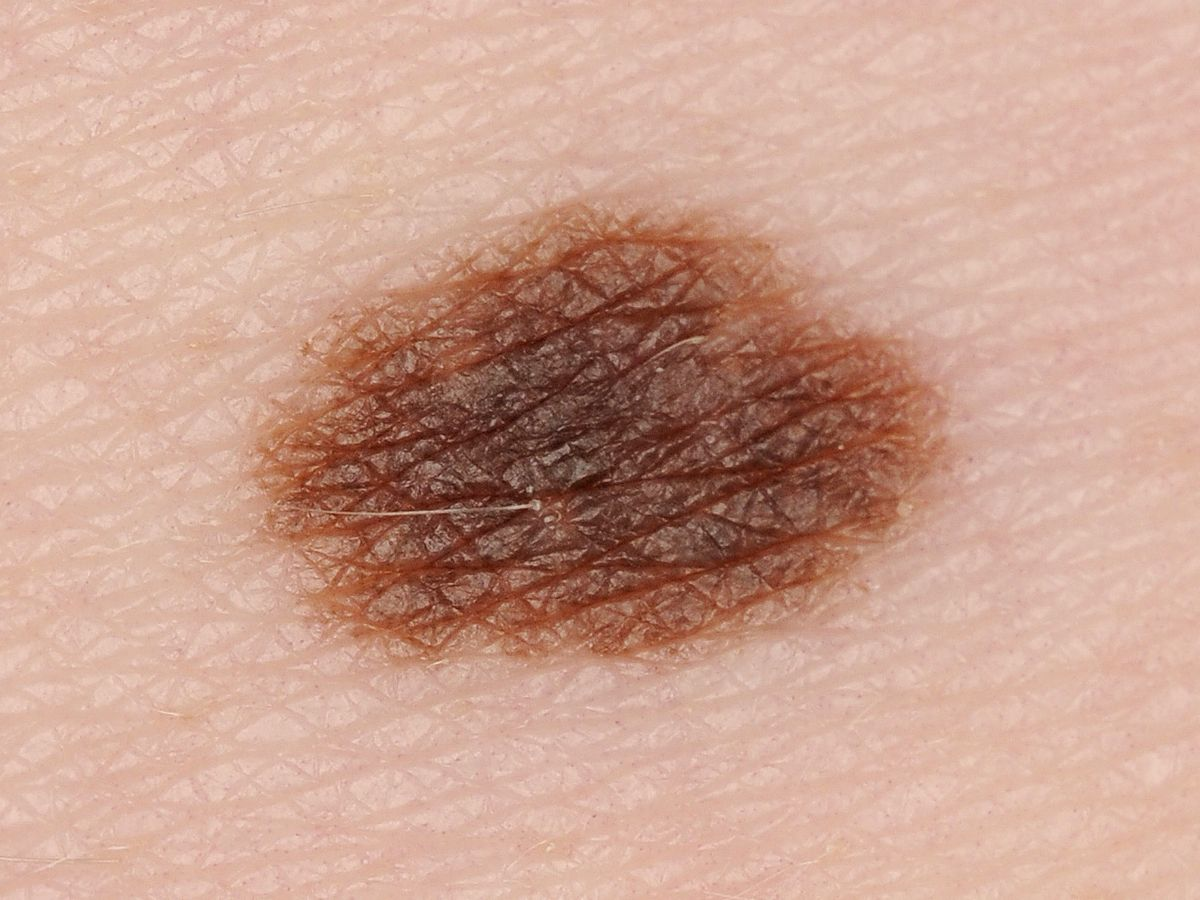

In [173]:
PATH_TO_IMAGE = '/content/naevusnaevocellularis1.jpg'
inputs = image_loader(PATH_TO_IMAGE)

predict_one_sample(model, inputs)

pil_img = Image(filename=PATH_TO_IMAGE)
display(pil_img)

In [ ]:
#@title LOADING MODEL FOR INFERENCE

In [ ]:
# Upload one or several images to predict diagnosis

input_image = files.upload()

In [15]:
# Load the pretrained model and make predictions

MODEL_PATH = '/content/gdrive/MyDrive/lesion_clas_resnet152_focalloss.pth'  ## '/content/gdrive/MyDrive/lesions_classifier_densenet.pth' 

model = torchvision.models.resnet152()
model.fc = nn.Linear(in_features=2048, out_features=3, bias=True)

In [ ]:
model.load_state_dict(torch.load(MODEL_PATH)['state_dict'])
model.cuda()

Lession in the image is: NEVUS


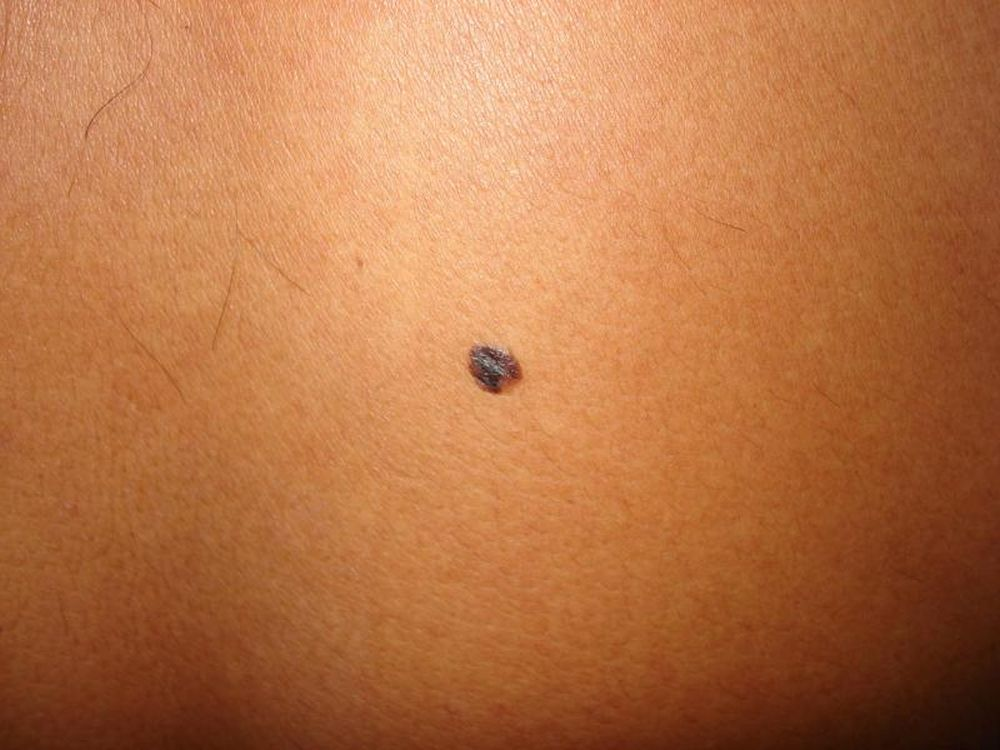

In [174]:
PATH_TO_IMAGE = 'melanoma (1).jpg'
inputs = image_loader(PATH_TO_IMAGE)

predict_one_sample(model, inputs)

pil_img = Image(filename=PATH_TO_IMAGE)
display(pil_img)

Lession in the image is: SEBORRHEIC_KERATOSIS


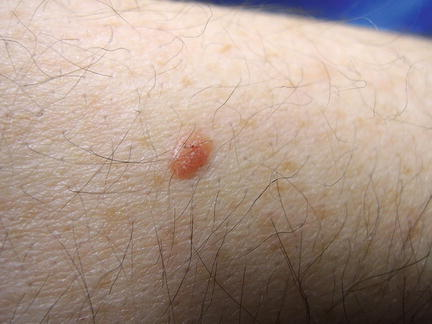

In [175]:
PATH_TO_IMAGE = '/content/sebor_kerat.jpg'
inputs = image_loader(PATH_TO_IMAGE)

predict_one_sample(model, inputs)

pil_img = Image(filename=PATH_TO_IMAGE)
display(pil_img)

Lession in the image is: MELANOMA


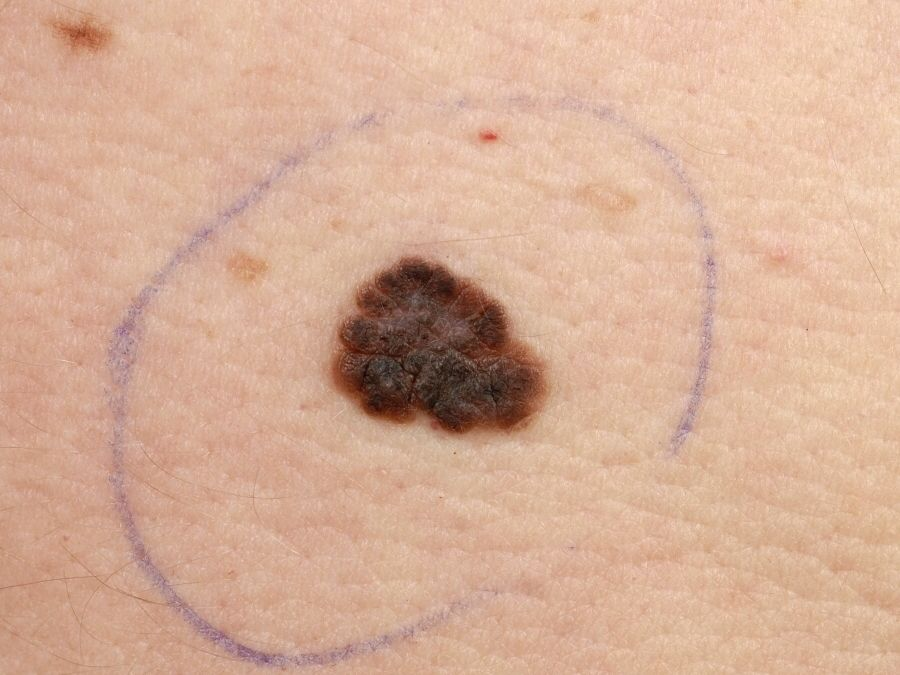

In [176]:
PATH_TO_IMAGE = '/content/melanoom-9.jpg'
inputs = image_loader(PATH_TO_IMAGE)

predict_one_sample(model, inputs)

pil_img = Image(filename=PATH_TO_IMAGE)
display(pil_img)

Lession in the image is: MELANOMA


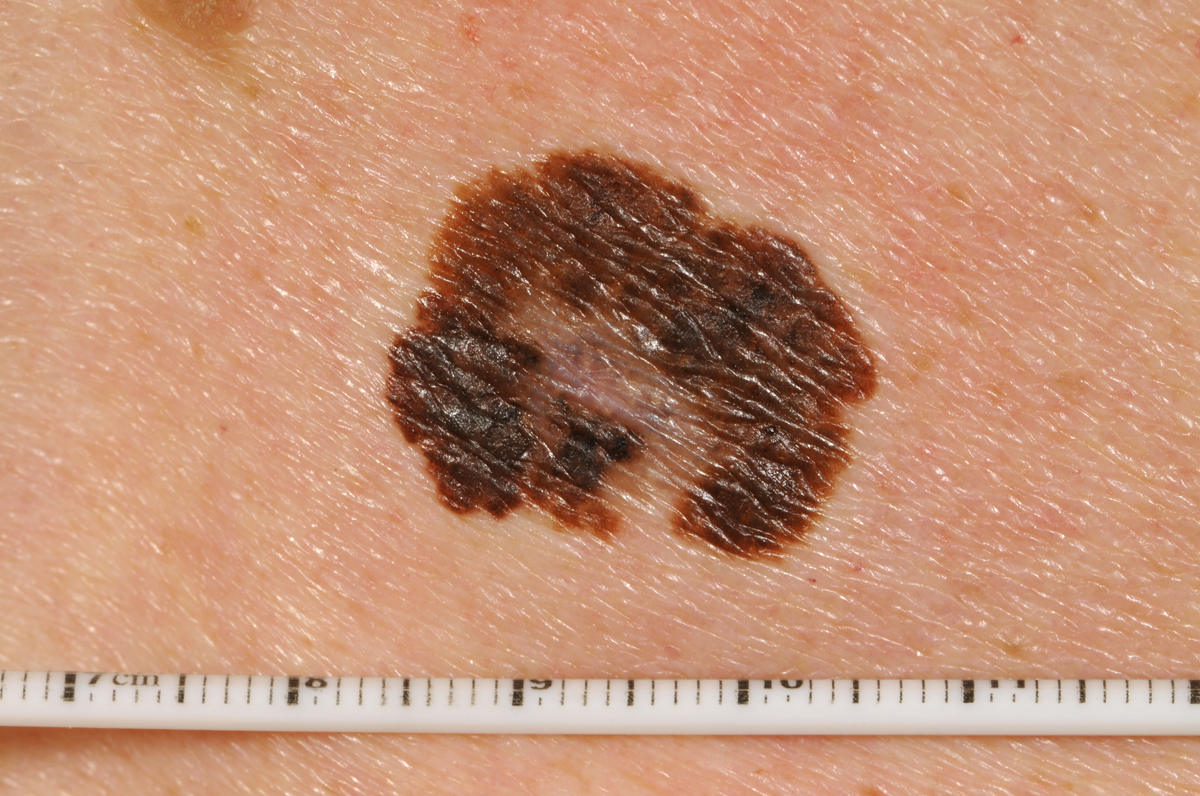

In [177]:
PATH_TO_IMAGE = '/content/melanoma.jpg'
inputs = image_loader(PATH_TO_IMAGE)

predict_one_sample(model, inputs)

pil_img = Image(filename=PATH_TO_IMAGE)
display(pil_img)

In [167]:
# I took couple of pictures on my body and I am going to check myself.
input_image = files.upload()

Saving IMG_20210226_115736.jpg to IMG_20210226_115736.jpg
Saving IMG_20210226_115721.jpg to IMG_20210226_115721.jpg


Lession in the image is: NEVUS


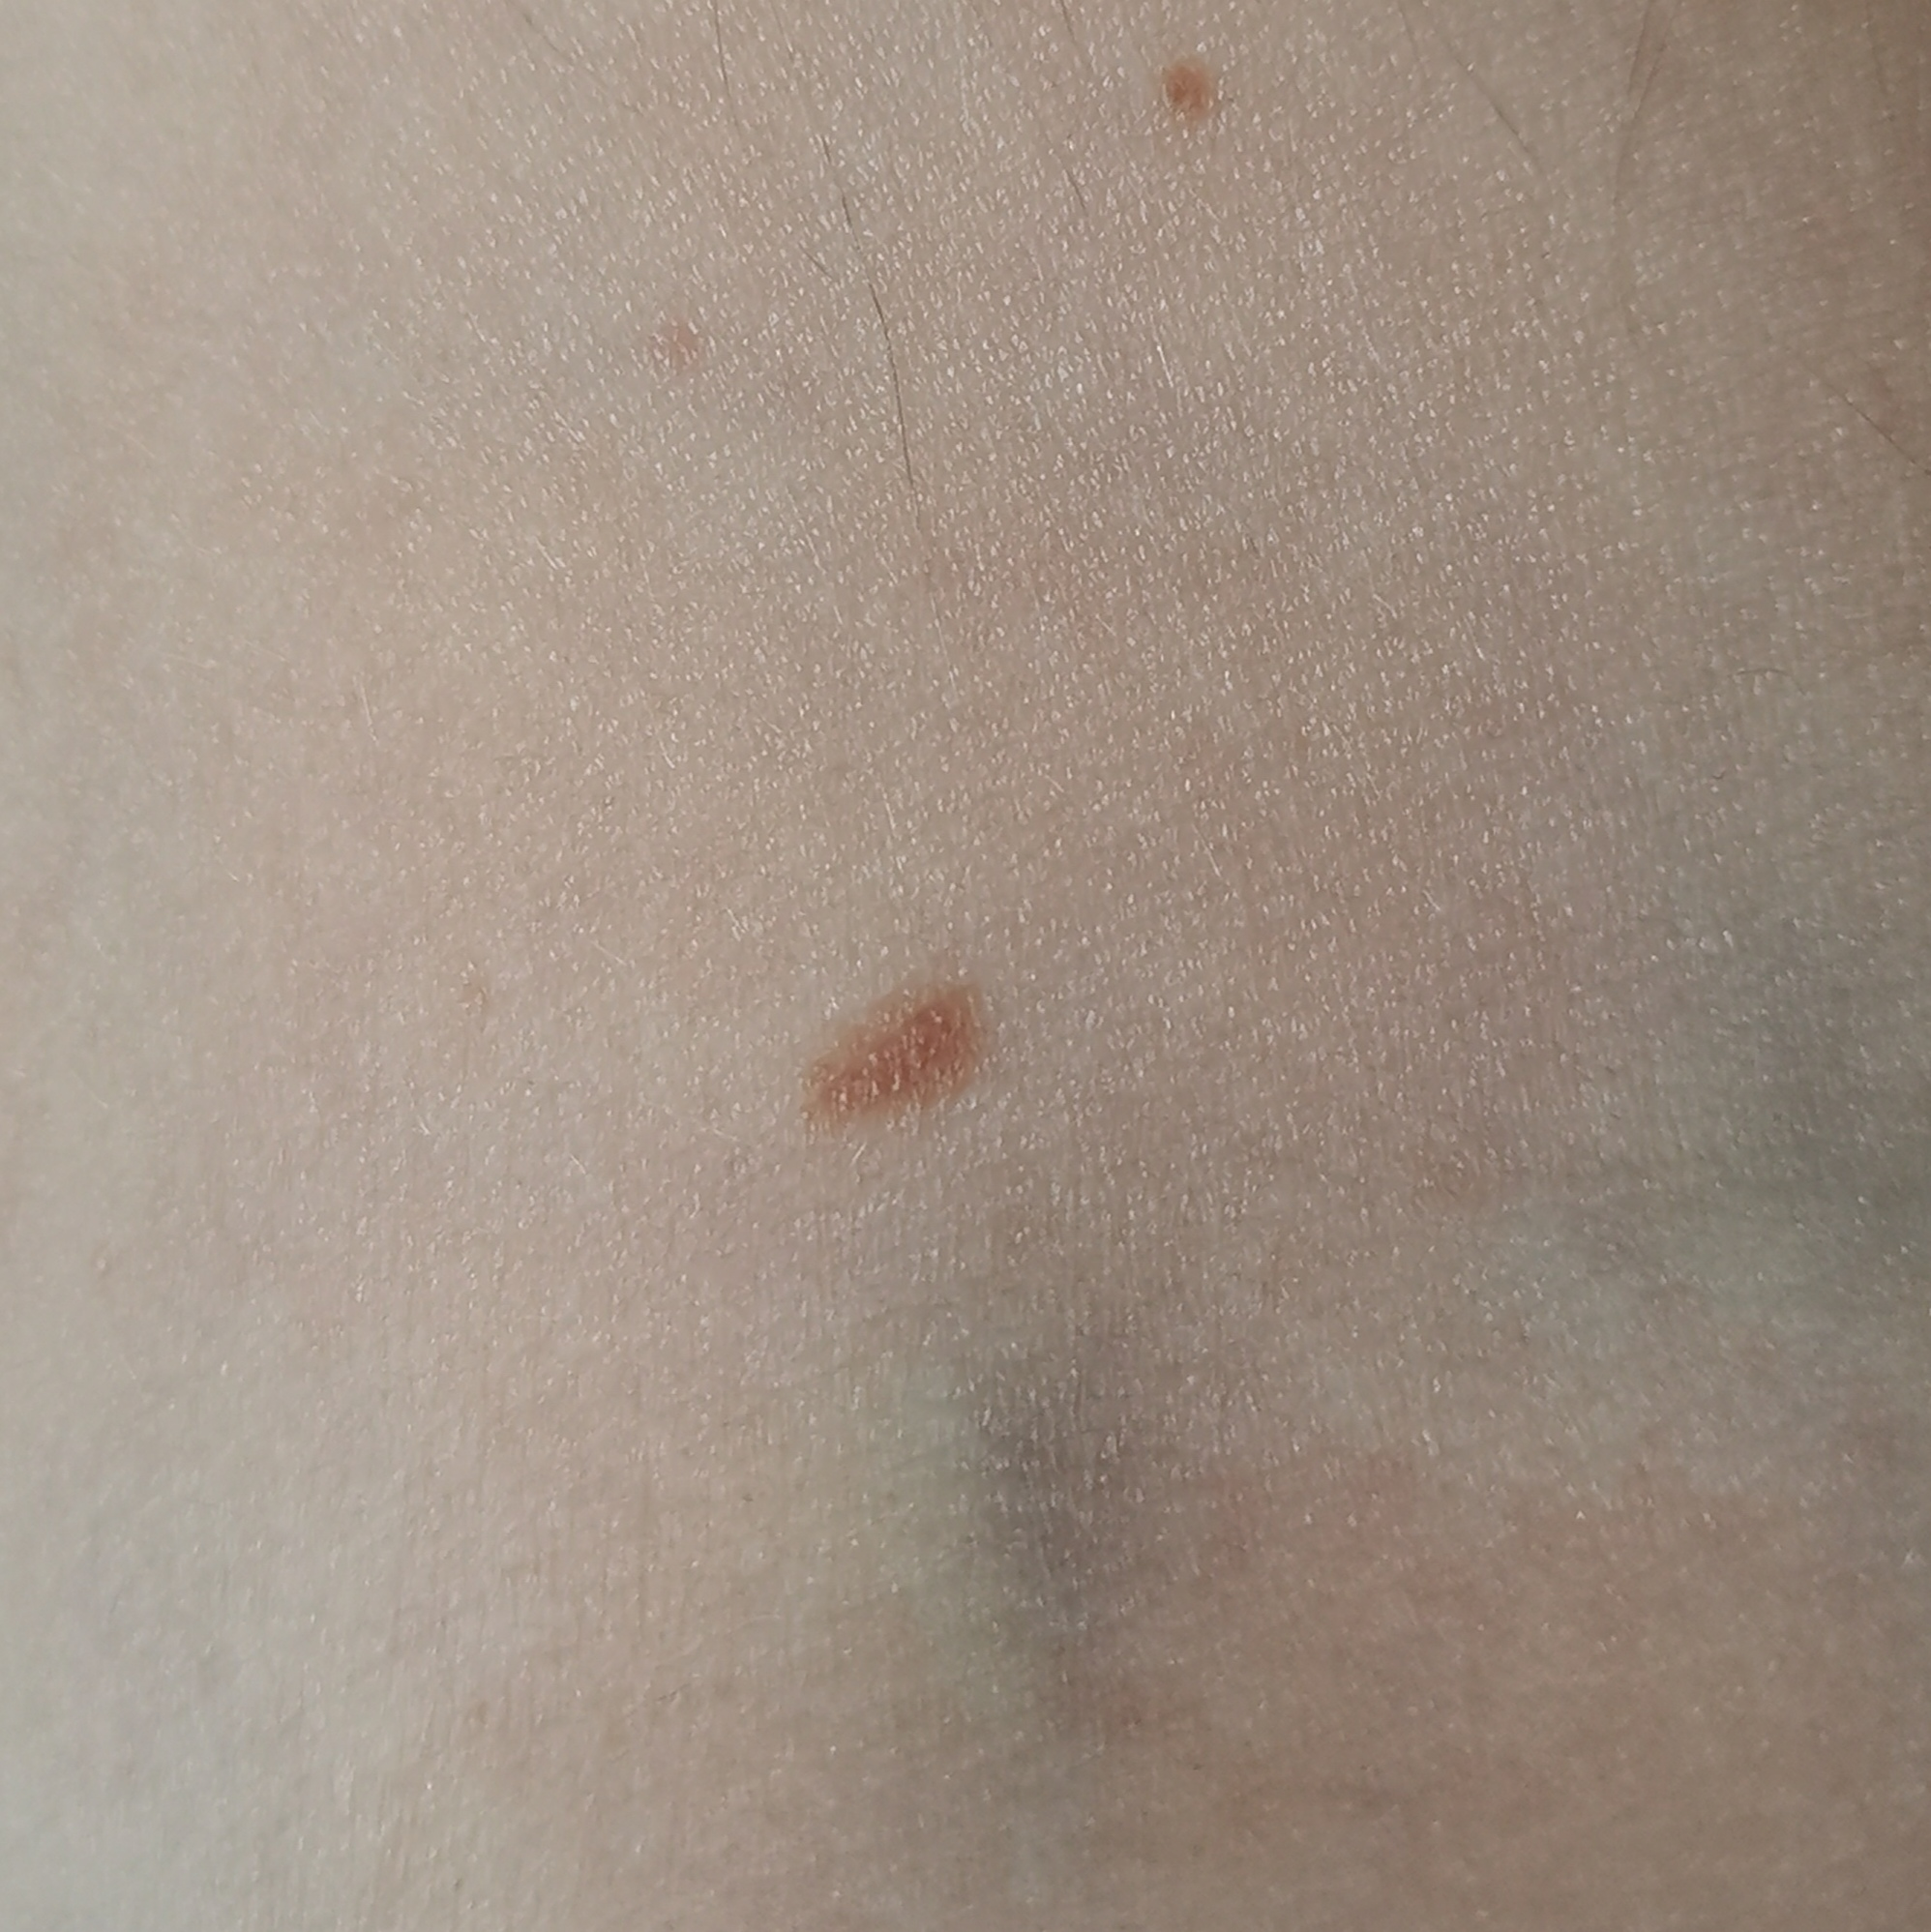

Lession in the image is: SEBORRHEIC_KERATOSIS


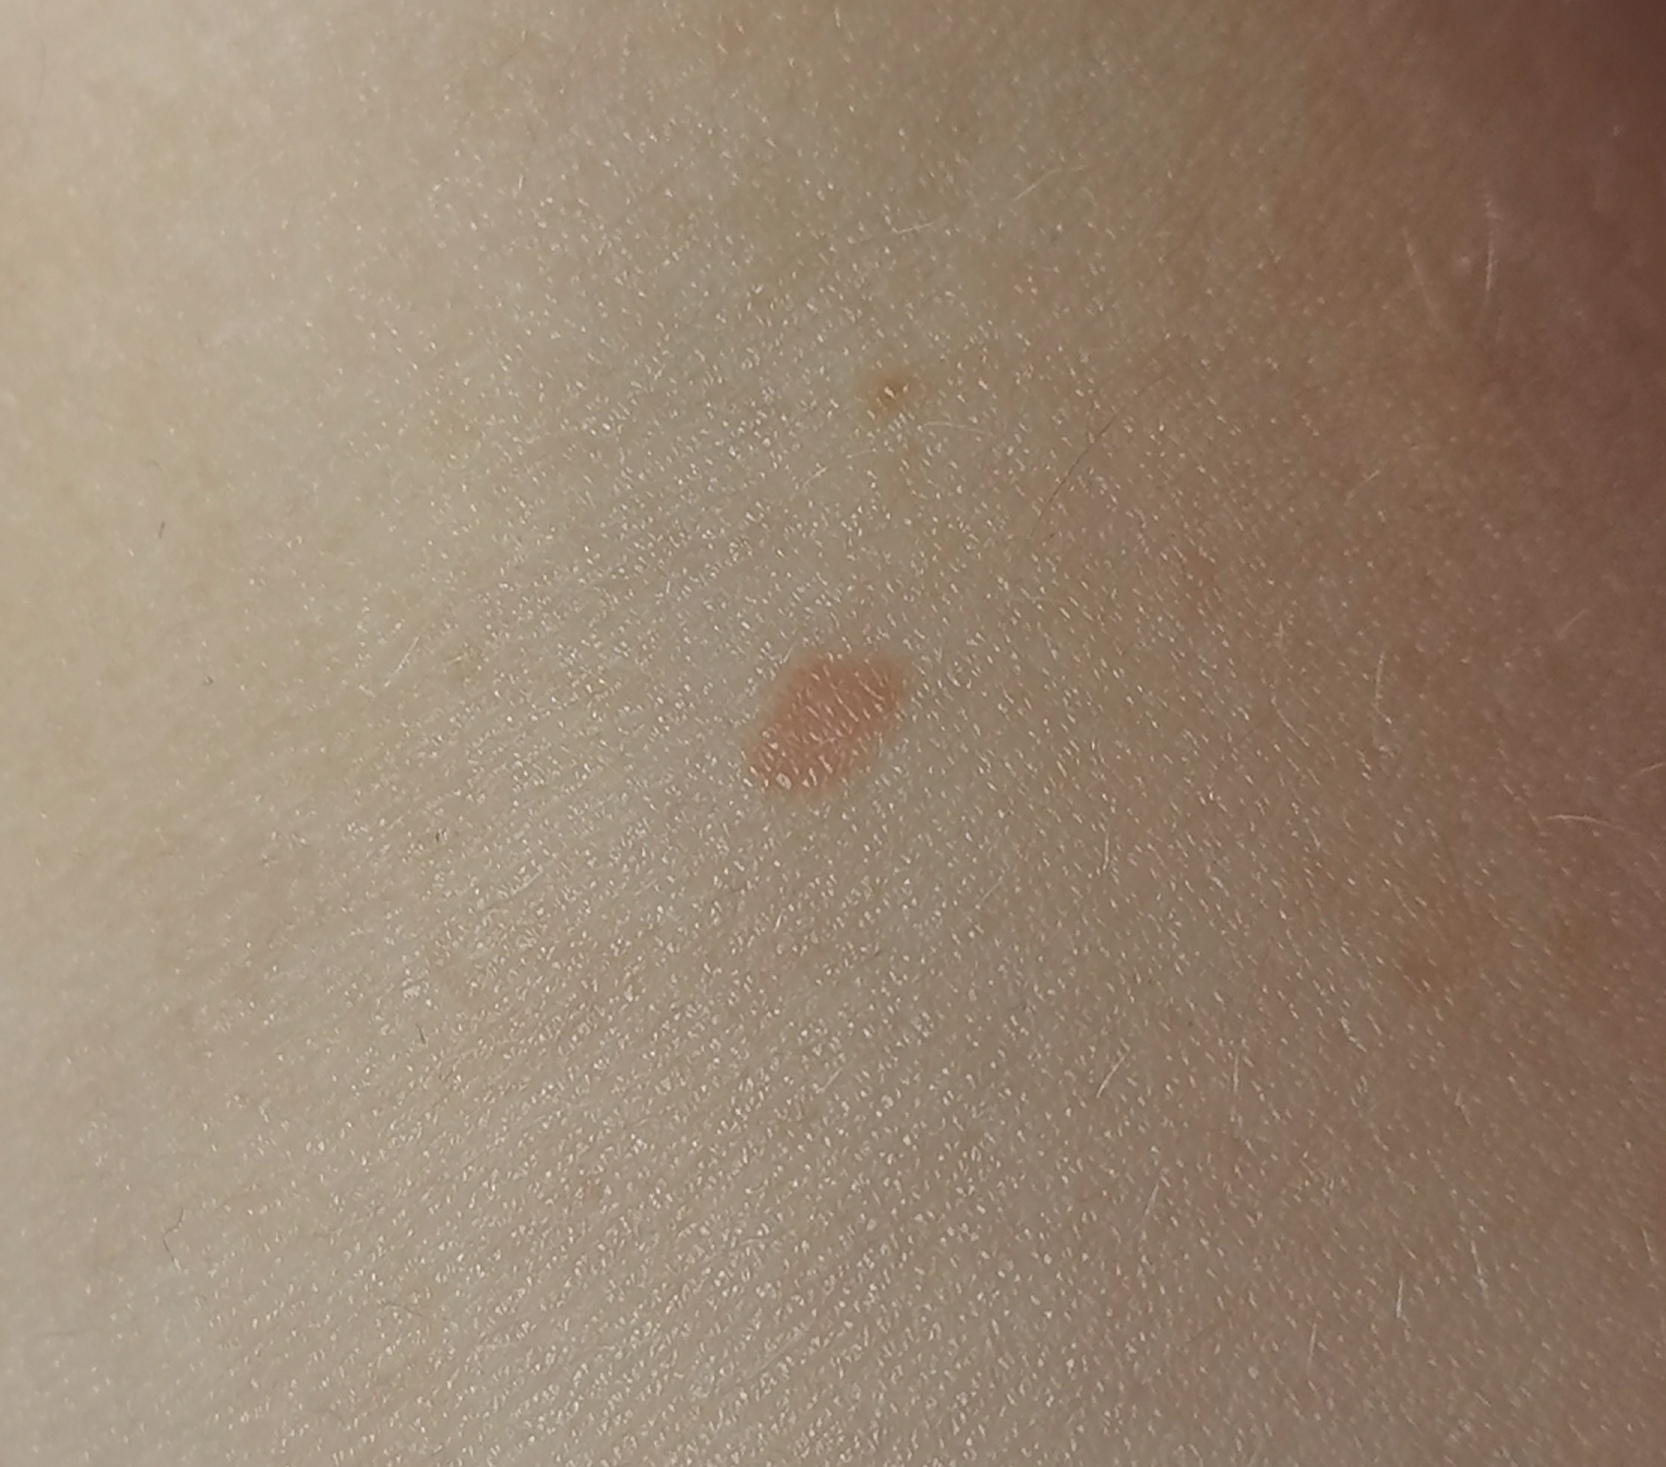

In [179]:
PATH_TO_IMAGE_1 = '/content/IMG_20210226_115736.jpg'
PATH_TO_IMAGE_2 =  'IMG_20210226_115721.jpg'
inputs_1 = image_loader(PATH_TO_IMAGE_1)
inputs_2 = image_loader(PATH_TO_IMAGE_2)

predict_one_sample(model, inputs_1)
pil_img = Image(filename=PATH_TO_IMAGE_1)
display(pil_img)

predict_one_sample(model, inputs_2)
pil_img = Image(filename=PATH_TO_IMAGE_2)
display(pil_img)